### **memory_models**

Run hierarchical models on project data:
- Explore whether age interacts with regionally specific aperiodic slopes to predict memory performance.

Author: EL Johnson, PhD

Copyright (c) 2022-2025  
ZR Cross, PhD & EL Johnson, PhD

### Set directories:

In [480]:
pth <- getwd() # navigate to directory containing folders of downloaded data
datdir <- paste(pth, 'Preprocessed_data', sep = '/')
savdir <- datdir # replace with your save path

### Load packages:  
If lme4 needs to be installed, run on the Anaconda command line:  
conda install -c conda-forge r-lme4

In [481]:
library(tidyverse)
library(RColorBrewer)
library(broom)
library(lme4)
library(splines)

### Build outlier detection function:

In [483]:
outlierKD <- function(dt, var) {
    var_name <- eval(substitute(var),eval(dt))
    tot <- sum(!is.na(var_name))
    na1 <- sum(is.na(var_name))
    m1 <- mean(var_name, na.rm = T)
    par(mfrow=c(2, 2), oma=c(0,0,3,0))
    boxplot(var_name, main='With outliers')
    hist(var_name, main='With outliers', xlab=NA, ylab=NA)
    outlier <- boxplot.stats(var_name)$out
    mo <- mean(outlier)
    var_name <- ifelse(var_name %in% outlier, NA, var_name)
    boxplot(var_name, main='Without outliers')
    hist(var_name, main='Without outliers', xlab=NA, ylab=NA)
    title('Outlier Check', outer=TRUE)
    na2 <- sum(is.na(var_name))
    message('Outliers identified: ', na2 - na1, ' from ', tot, ' observations')
    message('Proportion (%) of outliers: ', (na2 - na1) / tot*100)
    message('Mean of the outliers: ', mo)
    m2 <- mean(var_name, na.rm = T)
    message('Mean without removing outliers: ', m1)
    message('Mean if we remove outliers: ', m2)
    response <- readline(prompt='Do you want to remove outliers and to replace with NA? [yes/no]: ')
    if(response == 'y' | response == 'yes'){
        dt[as.character(substitute(var))] <- invisible(var_name)
        assign(as.character(as.list(match.call())$dt), dt, envir = .GlobalEnv)
        message('Outliers successfully removed', '\n')
        return(invisible(dt))
    } else{
        message('Nothing changed', '\n')
        return(invisible(var_name))
    }
}

### Load data:

In [484]:
dat_load <- paste(datdir, 'aperiodic_final_updated.csv', sep = '/')
df <- read.csv(dat_load, header = T)

dat_load <- paste(datdir, 'memory_performance.csv', sep = '/')
memory_data <- read.csv(dat_load)
colnames(memory_data)[1] <- 'subj'

# join memory performance to aperiodic data frame
df <- left_join(df, memory_data, by = c('subj', 'task'))

patient_data <- df %>%  
    select(subj, memory, age, task, condition) %>% 
    filter(condition == 'Task') %>% 
    group_by(subj, task, condition) %>% 
    summarise(memory = mean(memory), age = mean(age)) %>% 
    ungroup() %>% 
    select(-task, -condition) %>% 
    na.omit()
patient_data$condition <- 'pt'

In [485]:
# ensure our factors are indeed factors
patient_data$subj <- as.factor(patient_data$subj)
patient_data$condition <- as.factor(patient_data$condition)

# lets get the mean and standard deviation of performance
descriptive_memory <- patient_data %>% 
    summarise(average = mean(memory), sd = sd(memory))

# also grab the range
summary(patient_data$memory)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.01215 0.35192 0.54167 0.54289 0.75507 1.00000 

### Test age effects on memory in patients vs. controls:

In [486]:
# load control data
dat_load <- paste(datdir, 'memory_behav_controls.csv', sep = '/')
control_data <- read.csv(dat_load)

# ensure our factors are indeed factors
control_data$subj <- as.factor(control_data$subj)
control_data$condition <- as.factor(control_data$condition)

# join the two data frames together
behav_plot_df <- rbind(patient_data, control_data) %>% 
    filter(memory > 0)

# re-label group levels
behav_plot_df$condition <- factor(behav_plot_df$condition,levels=c('ctrl','pt'), labels=c('Control','Patient'))

# list subjects with memory performance data
subj_list <- as.data.frame(unique(patient_data$subj))

In [487]:
# run linear regression with two cubic splines for patient data only
patient_data <- filter(behav_plot_df, condition == 'Patient')

mem.age <- lm(memory ~ ns(age, df = 2), data = patient_data)
summary(mem.age)

# run mixed model comparing memory against zero
m1. <- lmer(memory ~ 1 + (1 | subj), data = patient_data, control = lmerControl(optimizer = 'bobyqa'))
summary(m1.)


Call:
lm(formula = memory ~ ns(age, df = 2), data = patient_data)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.46952 -0.14164 -0.01106  0.15326  0.53204 

Coefficients:
                 Estimate Std. Error t value    Pr(>|t|)    
(Intercept)       0.21775    0.06847   3.180     0.00205 ** 
ns(age, df = 2)1  0.89665    0.16072   5.579 0.000000275 ***
ns(age, df = 2)2  0.29926    0.13354   2.241     0.02761 *  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.2211 on 86 degrees of freedom
Multiple R-squared:  0.287,	Adjusted R-squared:  0.2704 
F-statistic: 17.31 on 2 and 86 DF,  p-value: 0.0000004817


boundary (singular) fit: see ?isSingular


Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: memory ~ 1 + (1 | subj)
   Data: patient_data
Control: lmerControl(optimizer = "bobyqa")

REML criterion at convergence: 16.3

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-2.05060 -0.73782 -0.00472  0.81981  1.76613 

Random effects:
 Groups   Name        Variance Std.Dev.
 subj     (Intercept) 0.00000  0.0000  
 Residual             0.06699  0.2588  
Number of obs: 89, groups:  subj, 81

Fixed effects:
            Estimate Std. Error       df t value            Pr(>|t|)    
(Intercept)  0.54289    0.02744 88.00000   19.79 <0.0000000000000002 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1
optimizer (bobyqa) convergence code: 0 (OK)
boundary (singular) fit: see ?isSingular


### Plot memory by age in patients and controls:

In [488]:
# create age values for prediction
age_values <- seq(from = min(patient_data$age, na.rm = TRUE), 
                  to = max(patient_data$age, na.rm = TRUE), 
                  length.out = 100)

# get predictions
mem.age.df <- data.frame(age = age_values)
mem.age.df$memory <- predict(mem.age, newdata = mem.age.df)

# extract confidence intervals
predictions <- predict(mem.age, newdata = mem.age.df, interval = 'confidence', level = 0.83)
mem.age.df$conf.low <- predictions[, 'lwr']
mem.age.df$conf.high <- predictions[, 'upr']

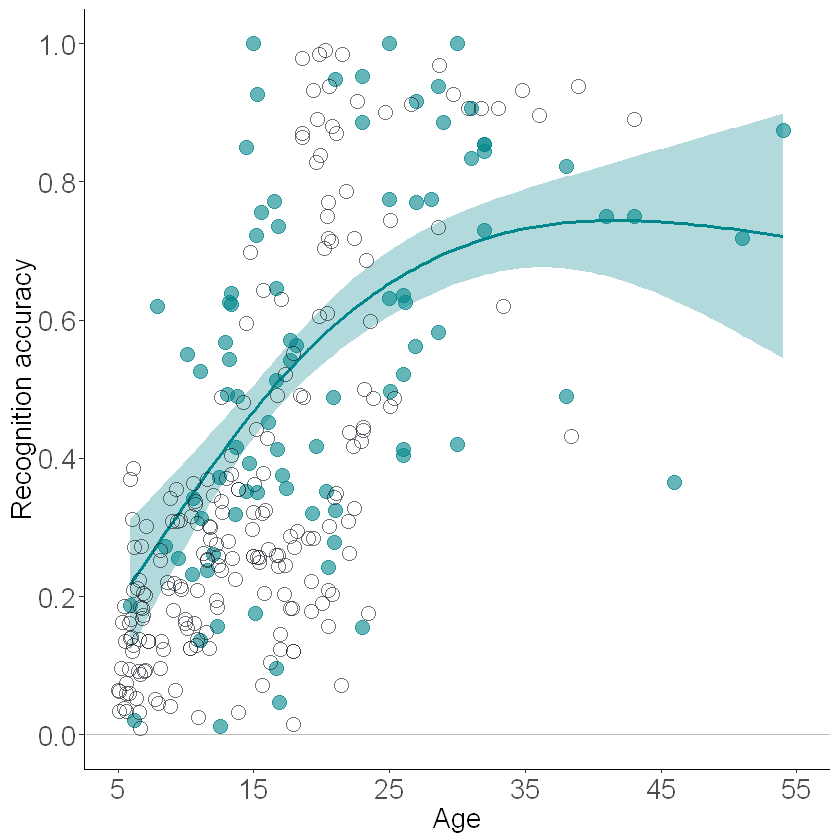

In [406]:
# plot
ggplot(mem.age.df, aes(age, memory)) +
    scale_linetype_manual(values = c('solid', 'longdash', 'solid')) +
    scale_fill_manual(values = c('turquoise4', 'turquoise4', 'turquoise4')) +
    geom_ribbon(aes(ymin = conf.low, ymax = conf.high), alpha = 0.3, fill = 'turquoise4') +
    geom_line(color = 'turquoise4', size = 1) + 
    scale_x_continuous(limits = c(5, 55), breaks = seq(5, 55, by = 10)) +
    scale_y_continuous(breaks = scales::pretty_breaks(n = 6)) +
    labs(y='Recognition accuracy', x = 'Age') +
        geom_hline(yintercept = 0, linetype = 'solid', color = 'grey', size = 0.5) +
    scale_shape_manual(values = c(1,19,1))+
    scale_color_manual(values = c('#101820FF','turquoise4','turquoise4'))+ 
    geom_point(aes(shape = condition, color = condition, fill = condition), alpha = 0.6, size = 4, data = behav_plot_df) +
    theme_classic() +  
    theme(legend.position = 'none',
        axis.title.x = element_text(size = 16),
        plot.title = element_text(size = 14, face = 'bold'),
        axis.title.y = element_text(size = 16),
        axis.text.x = element_text(size = 16),
        axis.text.y = element_text(size = 16),
        strip.text.x = element_text(size = 17),
        panel.grid.major = element_blank(), panel.grid.minor = element_blank())

### Prepare data frame for modeling:

In [489]:
# average over epochs and filter channels with a model fit of >.90
average_df <- df %>% 
    dplyr::select(subj, age, task, Slope, R.2, DKT, Offset, memory) %>%
    filter(task != 'Rest') %>% 
    group_by(subj, task, DKT) %>%
    dplyr::summarise(Slope = mean(Slope),
                     Offset = mean(Offset),
                     age = mean(age),
                     R.2 = mean(R.2),
                     memory = mean(memory)) %>% 
na.omit()

# factorize variables
average_df$subj <- factor(average_df$subj)
average_df$task <- factor(average_df$task)
average_df$DKT <- factor(average_df$DKT)

In [490]:
# filter out rest data
resting_state_df <- df %>% 
    dplyr::select(subj, age, condition, Slope, R.2, DKT, Offset, task) %>%
    filter(task == 'Rest' & condition != 'Task') %>% 
    group_by(subj, condition, DKT, task) %>%
    dplyr::summarise(Slope = mean(Slope),
                   Offset = mean(Offset),
                   age = mean(age),
                   R.2 = mean(R.2)) %>% 
na.omit()

memory_df <- average_df %>% 
    select(subj, memory, age, task) %>% 
    group_by(subj) %>% 
    summarise(memory = mean(memory), age = mean(age))

# join memory performance to resting-state slope
memory_rest <- left_join(memory_df, resting_state_df, by = c('subj', 'age')) %>% 
    select(-condition, -R.2) %>% 
na.omit()
memory_rest$subj <- as.factor(memory_rest$subj)
memory_rest$DKT <- as.factor(memory_rest$DKT)

overall_memory <- average_df %>% 
    select(subj, age, memory, task) %>% 
    group_by(subj, task) %>% 
    dplyr::summarise(memory = mean(memory), age = mean(age))

# get descriptive stats
mean_memory <- mean(overall_memory$memory)
sd_memory <- sd(overall_memory$memory)

# run model to examine memory performance
mem_model <- lm(memory ~ age, data = overall_memory)
summary(mem_model)


Call:
lm(formula = memory ~ age, data = overall_memory)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.49962 -0.16481 -0.03562  0.16908  0.53240 

Coefficients:
            Estimate Std. Error t value   Pr(>|t|)    
(Intercept) 0.275694   0.057067   4.831 0.00000578 ***
age         0.012794   0.002476   5.167 0.00000150 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.2277 on 87 degrees of freedom
Multiple R-squared:  0.2348,	Adjusted R-squared:  0.226 
F-statistic:  26.7 on 1 and 87 DF,  p-value: 0.000001495


### Remove slope outliers:

Outliers identified: 7 from 919 observations
Proportion (%) of outliers: 0.761697497279652
Mean of the outliers: 2.51931427915306
Mean without removing outliers: 2.05002378277113
Mean if we remove outliers: 2.04642177238223


Do you want to remove outliers and to replace with NA? [yes/no]:  yes


Outliers successfully removed



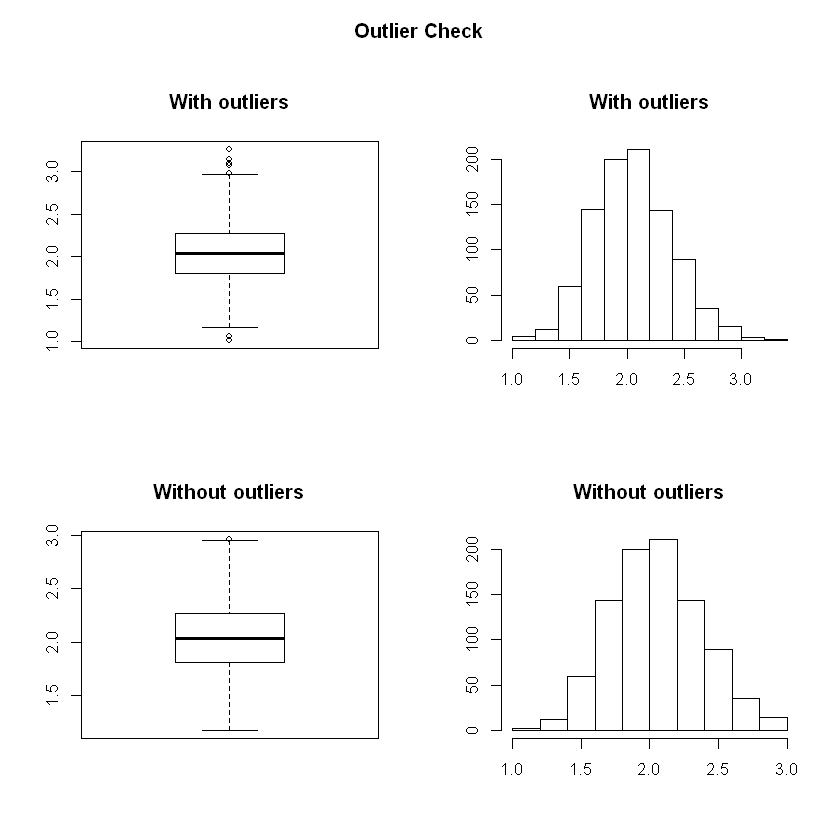

In [491]:
outlierKD(average_df, Slope)

### Run regression models:

In [492]:
# regression model function
run_lmm_and_extract_effects <- function(data) {
    data <- na.omit(data)  # filter out rows with missing values
    model <- lm(memory ~ Slope * age, data = data)
    
    # create prediction grid
    slope_range <- seq(min(data$Slope), max(data$Slope), length.out = 20)
    age_range <- seq(min(data$age), max(data$age), length.out = 20)
    pred_grid <- expand.grid(Slope = slope_range, age = age_range)
    
    # cet predictions with 83% CIs
    predictions <- predict(model, newdata = pred_grid, interval = 'confidence', level = 0.83)
    
    # create result data frame
    result <- data.frame(
        x = pred_grid$Slope,
        predicted = predictions[, 'fit'],
        conf.low = predictions[, 'lwr'],
        conf.high = predictions[, 'upr'],
        group = pred_grid$age
    )
    
    return(result)
}

In [493]:
# create an empty list to populate with DKT labels
DKT_levels <- unique(average_df$DKT)
combined_results <- data.frame() 
results_df_slope <- data.frame() 

# loop through DKT regions and save
for (level in DKT_levels) {
    cat('Processing DKT level:', level, '...\n')
    
    # subset the data
    subset_data <- average_df[average_df$DKT == level, ]
    
    # run lmer and extract effects
    results <- run_lmm_and_extract_effects(subset_data)

    # add the DKT level as a column in the results
    results$DKT <- level

    # append results to combined_results
    combined_results <- rbind(combined_results, results)
    
    # run lmer for slope results
    model <- lm(memory ~ Slope * age, data = subset_data)
    
    summary_model <- summary(model)
    
    # extract estimates, standard errors, and p-values for the fixed effects
    fixed_effects <- summary_model$coefficients[c(2, 3, 4), ]

    # create a new data frame to store the results for slope
    result_row <- data.frame(
        DKT = level,
        Estimate_Slope = fixed_effects[1, 'Estimate'],
        SE_Slope = fixed_effects[1, 'Std. Error'],
        PValue_Slope = fixed_effects[1, 'Pr(>|t|)'],
        Estimate_Age = fixed_effects[2, 'Estimate'],
        SE_Age = fixed_effects[2, 'Std. Error'],
        PValue_Age = fixed_effects[2, 'Pr(>|t|)'],
        Estimate_Interaction = fixed_effects[3, 'Estimate'],
        SE_Interaction = fixed_effects[3, 'Std. Error'],
        PValue_Interaction = fixed_effects[3, 'Pr(>|t|)']
    )
    
    # append the results to the main data frame for slope
    results_df_slope <- rbind(results_df_slope, result_row)
}

Processing DKT level: caudal middle frontal ...
Processing DKT level: fusiform ...
Processing DKT level: inferior parietal ...
Processing DKT level: inferior temporal ...
Processing DKT level: lateral occipital ...
Processing DKT level: middle temporal ...
Processing DKT level: parahippocampal ...
Processing DKT level: postcentral ...
Processing DKT level: superior temporal ...
Processing DKT level: caudal anterior cingulate ...
Processing DKT level: rostral middle frontal ...
Processing DKT level: posterior cingulate ...
Processing DKT level: precentral ...
Processing DKT level: superior parietal ...
Processing DKT level: medial orbitofrontal ...
Processing DKT level: inferior frontal ...
Processing DKT level: lateral orbitofrontal ...
Processing DKT level: hippocampus ...
Processing DKT level: subcortical ...
Processing DKT level: insula ...
Processing DKT level: amygdala ...


In [494]:
# combine the results into a single data frame
combined_results <- combined_results %>% 
    rename(memory = predicted, Slope = x, age = group)

# generate table of all results for aperiodic slope
slope_table <- results_df_slope %>% 
    dplyr::rename(ROI = DKT, P_Age = PValue_Age, P_Slope = PValue_Slope, P_Interaction = PValue_Interaction)

### Save model results:

In [495]:
dat_save <- paste(savdir, 'results_slope_memory.csv', sep = '/')
write.csv(slope_table, dat_save, row.names = FALSE)

### Plot slope effects:

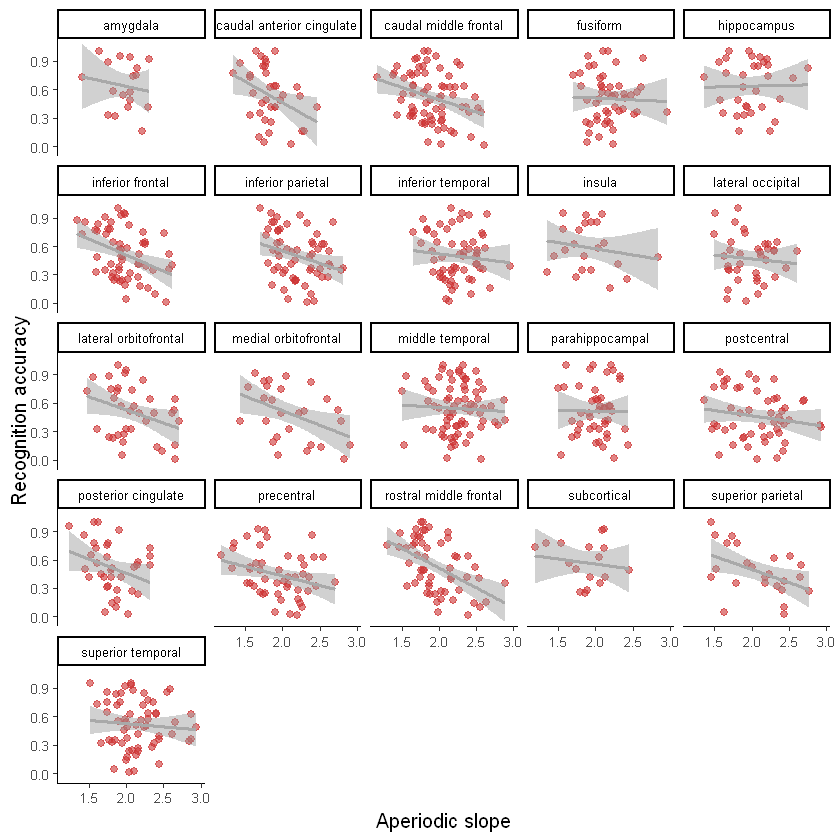

In [496]:
ggplot(average_df, aes(x = Slope, y = memory)) + 
    geom_point(color = 'brown3', alpha = 0.6, size = 2) +  # change to brick red
    geom_smooth(method = 'lm', linetype = 'solid', color = 'darkgray') +
    geom_ribbon(aes(ymin = ..ymin.., ymax = ..ymax..), stat = 'smooth', method = 'lm', fill = 'darkgray', alpha = 0.1) + 
    facet_wrap(~DKT) +
    scale_color_viridis_c(option = 'magma') +
    xlab('Aperiodic slope') + ylab ('Recognition accuracy') +
    theme_classic() +
    theme(legend.position = 'none',
        legend.spacing.x = unit(0.1, 'cm'),
        legend.key.size = unit(0.5, 'cm'),
        legend.background = element_rect(fill = alpha('blue', 0)),
        legend.text = element_text(size = 8, colour = 'black'),
        legend.title = element_text(size = 8, colour = 'black'),
        strip.text.x = element_text(size = 8, colour = 'black'),
        strip.text.y = element_text(size = 8, colour = 'black'),
        axis.text = element_text(size = 8),
        axis.title = element_text(size = 12),
        plot.title = element_text(size = 8, face = 'bold'))

### Plot slope*age interaction in rMFG:

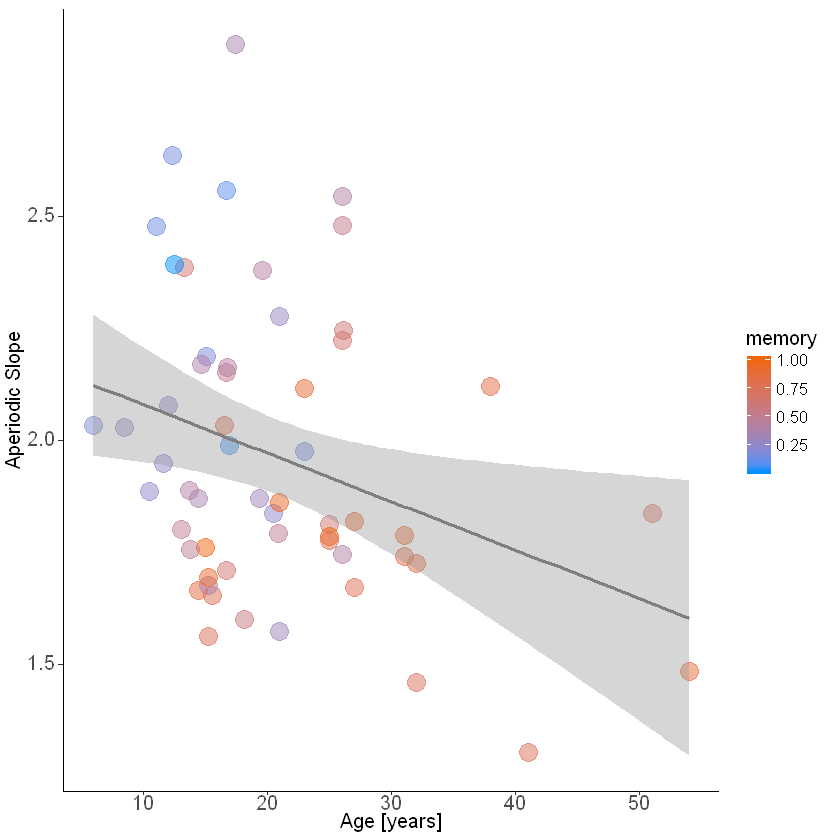

In [497]:
ggplot(filter(average_df, DKT == 'rostral middle frontal'), aes(x = age, y = Slope, color = memory)) + 
    geom_point(alpha = .5, size = 5) +
    geom_smooth(method = 'lm', linetype='solid', colour = 'gray50') +
    scale_color_gradient(low = '#0091ff', high = '#f0650e', name = 'memory') +
    labs(x='Age [years]', y = 'Aperiodic Slope') +
    theme_classic()  +
    theme(legend.position='right',
        legend.spacing.x = unit(0.1, 'cm'),
        legend.key.size = unit(0.5, 'cm'),
        legend.background = element_rect(fill=alpha('blue', 0)),
        legend.text = element_text(size = 10, colour = 'black'),
        legend.title = element_text(size = 12, colour = 'black'),
        strip.text.x = element_text(size = 12, colour = 'black'),
        strip.text.y = element_text(size = 12, colour = 'black'),
        axis.text = element_text(size = 12),
        axis.title = element_text(size = 12),
        plot.title = element_text(size = 10, face = 'bold'))